Demo of signals that can be pulled out of utterances:

The goal of this project is to demonstrate different signals that could be pulled out from utterances automatically, without any manual analysis.  

The project in its current state is of purely an exploratory nature, using only 2000 possible utterances that I have fabricated for the purpose of this exercise, I have them in Italian(not Latin) as to not distract from the code.

This is done in three sections:
1: Matching intent(or slots, or ASR strings) and TTS
2: Using data points like confidence and city to triangulate against one intent, in this case hours
3: Use NaiveBayes ML models to use the words in the questions themselves to pull out signals

------------------------

1) Our first goal would be to match and individuate errors using Intent and TTS to bucketize errors based on whether or not the user intent was fulfilled.

In [1]:

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
# nltk.download('stopwords')
# nltk.download('punkt')
from collections import Counter

In [2]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
try:
    sc
    spark
except NameError:
    sc = SparkContext('local')
    spark = SparkSession(sc)

from pyspark import SparkFiles

In [3]:
#define
top_N = 10000
stopwords = set('italian')
stopwords = nltk.corpus.stopwords.words('italian')
utterances = pd.read_csv('tool_testing.csv')
# utterances.head()

In [4]:
import re
total_intent_yes = 0
total_attrib_yes = 0
for index, row in utterances.iterrows():  
    if re.match("IsOpenIntent|GetClosingTimeIntent|GetHoursIntent|GetOpeningTimeIntent|IsClosedIntent", row["TTS_Intent"]):
        utterances.loc[index, "includes"] = "yes"
        total_intent_yes = total_intent_yes + 1
        if re.search("^.*dalle (\d{2}:\d{2}) alle (\d{2}:\d{2}).*$", row["TTS"]):
            utterances.loc[index, "attribute"] = "yes"
            total_attrib_yes = total_attrib_yes + 1
    else:
        utterances.loc[index, "includes"] = "no"

In [5]:
print(total_intent_yes-total_attrib_yes)

    


683


In [6]:
print(total_attrib_yes/total_intent_yes)

0.13324873096446702


Conclusion of first goal: This process needs to be refined and needs to be bucketized per intent, however, the picture given is certainly useful and could elaborated extensively.  The idea here would be to create a system of pairs using Regex: on one side, the presence of a slot(PlaceType, PlaceName, etc.), intent and ASR to ascertain the content type the customer is looking to consume.  In this case we can determine that if the answer has hours in it, then the customer will have at least received the type of content they're looking for.  In a later iteration we could look for signals such as distance between customer and Point of Interest(POI), whether or not the POI is a Chain, parse out category searches(restaurant, coffee shop, etc.) to get an even clearer idea of whether or not the pair succeeded.  For local search (looking for POIs or services close to the user) we could create the following buckets with this automated process:

	Category
ct1	"No" Answer Given
ct2	Category Correct / Wrong POI or  List
ct3	Wrong Category
ct4	Wants Category / Gets Attribute
ct5	Wants Category / Gets Chain
ct6	Wants Category / Gets Traffic -Directions
	
	Chain
ch1	"No" Answer Given
ch2	Wants Closest / Wrong PoI or List
ch3	Wrong Chain
ch4	Wants Closest / Gets Attribute
ch5	Wants Closest / Gets Category
ch6	Wants Closest / Gets Traffic -Directions
	
	POI/Attribute
p1	"No" Answer Given
p2	Right Attribute / Wrong POI or List
p3	Gets Wrong Attribute
p4	Wants Attribute / Gets  Category
p5	Wants Attribute / Gets Chain
p6	Wants Attribute / Gets Traffic - Directions
	
	Navigation
n1	"No" Answer Given
n2	Wants Directions / Wrong POI or List
n3	Wrong Traffic - Directions 
n4	Wants Directions-Traffic / Gets Attribute
n5	Wants Directions-Traffic / Gets Category
n6	Wants Directions-Traffic / Gets Chain

In [7]:
intent = utterances.dropna()
# intent.head()

In [8]:
oth = utterances[utterances["attribute"].isnull()] 
# oth.head()

In [9]:
# Groupby_city
oth_by_city = oth.groupby(["city"])
intent_by_city = intent.groupby(["city"])
# intent_by_city.head()

In [10]:
oth_city = oth_by_city.city.count()
intent_city = intent_by_city.city.count()

intent_city.head(50)                      

city
Alpo VR, Italy                                                   3
Basella, Province of Bergamo, Italy                              2
Belfiore, Metropolitan City of Florence, Italy                   3
Bulgorello CO, Italy                                             2
Busto Arsizio, VA, Italy                                         1
Caronno Pertusella, VA, Italy                                    2
Costeggiola VR, Italy                                            2
Florence, Metropolitan City of Florence, Italy                   2
Forcoli, Province of Pisa, Italy                                 1
Gallarate, VA, Italy                                             3
Gorgonzola, Metropolitan City of Milan, Italy                    4
Imola, Metropolitan City of Bologna, Italy                       1
Legnano, Metropolitan City of Milan, Italy                       2
Livorno, Province of Livorno, Italy                              1
Lugano, Switzerland                                      

In [11]:
#Missing attribute coverage by city
oth_city.head(60)

city
44.73271                                                                               1
Acqui Terme, Province of Alessandria, Italy                                            2
Agliano Terme, Province of Asti, Italy                                                 2
Alba, Province of Cuneo, Italy                                                         2
Albairate MI, Italy                                                                    2
Albese con Cassano, Province of Como, Italy                                            1
Albignasego, Province of Padua, Italy                                                  4
Alessandria, Province of Alessandria, Italy                                            5
Alghero, Province of Sassari, Italy                                                    1
Alpignano, Metropolitan City of Turin, Italy                                           2
Alpo VR, Italy                                                                         3
Anacapri NA, Ita

In [12]:
#intent confidence by city
oth_confidence_per_city = oth_by_city.Score.sum()
intent_confidence_per_city = intent_by_city.Score.sum()

intent_confidence_per_city.head()

city
Alpo VR, Italy                                    1.469716
Basella, Province of Bergamo, Italy               0.430843
Belfiore, Metropolitan City of Florence, Italy    1.231022
Bulgorello CO, Italy                              1.022413
Busto Arsizio, VA, Italy                          0.466272
Name: Score, dtype: float64

In [13]:
#Missing Attribute, Confidence by city
oth_confidence_per_city.head()

city
44.73271                                       0.295040
Acqui Terme, Province of Alessandria, Italy    0.733091
Agliano Terme, Province of Asti, Italy         1.089073
Alba, Province of Cuneo, Italy                 1.042696
Albairate MI, Italy                            0.216826
Name: Score, dtype: float64

In [14]:
#Mean-words
oth_mean = oth_confidence_per_city / oth_city
intent_mean = intent_confidence_per_city / intent_city


intent_mean.head()

city
Alpo VR, Italy                                    0.489905
Basella, Province of Bergamo, Italy               0.215422
Belfiore, Metropolitan City of Florence, Italy    0.410341
Bulgorello CO, Italy                              0.511207
Busto Arsizio, VA, Italy                          0.466272
dtype: float64

In [15]:
#Looking at the answers in this bucket
intent["TTS_Intent"].value_counts()

IsClosedIntent Uno dei centri commerciali più vicini trovati si chiama MediaWorld, in Viale Certosa 29 a Milano. Questa attività è aperta mercoledì dalle 09:00 alle 20:30.                                                                               4
IsOpenIntent Uno dei centri commerciali più vicini trovati si chiama MediaWorld, in Viale Certosa 29 a Milano. Questa attività è aperta mercoledì dalle 09:00 alle 20:30.                                                                                 4
IsOpenIntent Mangia Napoli in Viale Agosta, 39, a Roma, è aperto il 30/7/2019 dalle 12:30 alle 14:45, e il 30/7/2019 dalle 19:30 alle 23:45.                                                                                                              3
GetOpeningTimeIntent È aperto oggi, dalle 08:00 alle 13:00 e oggi, dalle 16:00 alle 20:00.                                                                                                                                                          

In [16]:
#Looking at the answers in this bucket
oth["TTS_Intent"].value_counts()

SearchPlaceIntent Mi spiace, non lo so. Per ora posso cercare numeri di telefono, orari e indirizzi.                                                                                                                                                                                61
GetPhoneNumberIntent Mi spiace, non lo so. Per ora posso cercare numeri di telefono, orari e indirizzi.                                                                                                                                                                             53
GetAddressIntent Mi spiace, non lo so. Per ora posso cercare numeri di telefono, orari e indirizzi.                                                                                                                                                                                 43
IsOpenIntent Mi spiace, non lo so. Per ora posso cercare numeri di telefono, orari e indirizzi.                                                                    

In [17]:
#Plotting by city
utterances = utterances.set_index(["city"])
utterances_index = utterances.sort_index()

utterances_index.head()

,Audio Link,Decoder used,Date / Time,Transcription,Recognition,Diff,Annotated Domain,Annotated Intent,Annotated Slots,NLU Domain,...,desired_answer,NLU Slots,Score,TTS,TTS_Intent,Latitude,Longitude,Tessaract Link,includes,attribute
city,,,,,,,,,,,,,,,,,,,,,
44.73271,https://coldplay.amazon.com/datamart/content/a...,BgSLM,2019-08-13 18:47:36,a che ora chiude il negozio gazzotti sport di ...,a che ora chiude il negozio gazzotti sport di ...,",",LocalSearch,GetClosingTimeIntent,"""PlaceType: negozio\nCity: reggio emilia\nPlac...",LocalSearch,...,hours,"""City: reggio emilia\nPlaceType: negozio\nActi...",0.295040,Uno dei centri commerciali trovati si chiama G...,GetClosingTimeIntent Uno dei centri commercial...,10.57444,https://alexa-localsearch-tesseract.integ.amaz...,NaN,yes,NaN
"Acqui Terme, Province of Alessandria, Italy",https://coldplay.amazon.com/datamart/content/a...,BgSLM,2019-07-05 21:34:16,orari [bg] di [bg] apertura del ristorante munsha,orari di apertura del ristorante muscia,"-munsha, +muscia",LocalSearch,GetOpeningTimeIntent,"""PlaceName: ristorante munsha\n""",LocalSearch,...,hours,"""PlaceName: muscia\nPlaceType: ristorante\n""",0.366545,Gli orari di apertura del Tomassini e Zangari ...,GetOpeningTimeIntent Gli orari di apertura del...,44.67410,8.4606,https://alexa-localsearch-tesseract.integ.amaz...,yes,NaN
"Acqui Terme, Province of Alessandria, Italy",https://coldplay.amazon.com/datamart/content/a...,BgSLM,2019-07-05 21:34:16,orari [bg] di [bg] apertura del ristorante munsha,orari di apertura del ristorante muscia,"-munsha, +muscia",LocalSearch,GetOpeningTimeIntent,"""PlaceName: ristorante munsha\n""",LocalSearch,...,hours,"""PlaceName: muscia\nPlaceType: ristorante\n""",0.366545,Gli orari di apertura del Tomassini e Zangari ...,GetOpeningTimeIntent Gli orari di apertura del...,44.67410,8.4606,https://alexa-localsearch-tesseract.integ.amaz...,yes,NaN
"Agliano Terme, Province of Asti, Italy",https://coldplay.amazon.com/datamart/content/a...,BgSLM,2019-07-17 09:53:33,dimmi i ristoranti che ci sono in zona,dim mi il ristorante che ci sono in zona,"-dimmi-i-ristoranti, +dim+mi+il+ristorante",LocalSearch,GetPlaceListingsIntent,"""City: pisa\nSpokenModeTrigger: dici\nPlaceTyp...",LocalSearch,...,SearchPlaceIntent,"""City: pisa\nSpokenModeTrigger: dici\nPlaceTyp...",0.544537,"Ecco alcuni dei ristoranti: uno, il Ristorante...",SearchPlaceIntent Ecco alcuni dei ristoranti: ...,44.78853,8.24955,https://alexa-localsearch-tesseract.integ.amaz...,no,NaN
"Agliano Terme, Province of Asti, Italy",https://coldplay.amazon.com/datamart/content/a...,BgSLM,2019-07-17 09:53:33,dimmi i ristoranti che ci sono in zona,dim mi il ristorante che ci sono in zona,"-dimmi-i-ristoranti, +dim+mi+il+ristorante",LocalSearch,GetPlaceListingsIntent,"""City: pisa\nSpokenModeTrigger: dici\nPlaceTyp...",LocalSearch,...,SearchPlaceIntent,"""City: pisa\nSpokenModeTrigger: dici\nPlaceTyp...",0.544537,"Ecco alcuni dei ristoranti: uno, il Ristorante...",SearchPlaceIntent Ecco alcuni dei ristoranti: ...,44.78853,8.24955,https://alexa-localsearch-tesseract.integ.amaz...,no,NaN


In [18]:
#Bobbles 1
df_city_middle = utterances_index.loc[utterances_index["Score"] > .10]
df_city_super = utterances_index.loc[utterances_index["Score"] >= .50]
df_city_not_bad = df_city_middle.loc[df_city_middle["Score"] < .50]
df_city_not_good = utterances_index.loc[utterances_index["Score"] < 10]

df_city_super.head()

,Audio Link,Decoder used,Date / Time,Transcription,Recognition,Diff,Annotated Domain,Annotated Intent,Annotated Slots,NLU Domain,...,desired_answer,NLU Slots,Score,TTS,TTS_Intent,Latitude,Longitude,Tessaract Link,includes,attribute
city,,,,,,,,,,,,,,,,,,,,,
"Agliano Terme, Province of Asti, Italy",https://coldplay.amazon.com/datamart/content/a...,BgSLM,2019-07-17 09:53:33,dimmi i ristoranti che ci sono in zona,dim mi il ristorante che ci sono in zona,"-dimmi-i-ristoranti, +dim+mi+il+ristorante",LocalSearch,GetPlaceListingsIntent,"""City: pisa\nSpokenModeTrigger: dici\nPlaceTyp...",LocalSearch,...,SearchPlaceIntent,"""City: pisa\nSpokenModeTrigger: dici\nPlaceTyp...",0.544537,"Ecco alcuni dei ristoranti: uno, il Ristorante...",SearchPlaceIntent Ecco alcuni dei ristoranti: ...,44.788530,8.24955,https://alexa-localsearch-tesseract.integ.amaz...,no,NaN
"Agliano Terme, Province of Asti, Italy",https://coldplay.amazon.com/datamart/content/a...,BgSLM,2019-07-17 09:53:33,dimmi i ristoranti che ci sono in zona,dim mi il ristorante che ci sono in zona,"-dimmi-i-ristoranti, +dim+mi+il+ristorante",LocalSearch,GetPlaceListingsIntent,"""City: pisa\nSpokenModeTrigger: dici\nPlaceTyp...",LocalSearch,...,SearchPlaceIntent,"""City: pisa\nSpokenModeTrigger: dici\nPlaceTyp...",0.544537,"Ecco alcuni dei ristoranti: uno, il Ristorante...",SearchPlaceIntent Ecco alcuni dei ristoranti: ...,44.788530,8.24955,https://alexa-localsearch-tesseract.integ.amaz...,no,NaN
"Alba, Province of Cuneo, Italy",https://coldplay.amazon.com/datamart/content/a...,BgSLM,2019-07-09 21:13:18,un numero di telefono di amazon <incidental> <ms>,numero di telefono di amazon,"-un,",LocalSearch,GetPlaceListingsIntent,"""Proximity: vicino\nPlaceName: esselunga\nAnap...",LocalSearch,...,SearchPlaceIntent,"""PlaceName: esselunga\nLocationSortType: vicin...",0.521207,Il numero di telefono di uno dei Amazon Locker...,SearchPlaceIntent Il numero di telefono di uno...,44.686200,8.0325,https://alexa-localsearch-tesseract.integ.amaz...,no,NaN
"Alba, Province of Cuneo, Italy",https://coldplay.amazon.com/datamart/content/a...,BgSLM,2019-07-09 21:13:18,un numero di telefono di amazon <incidental> <ms>,numero di telefono di amazon,"-un,",LocalSearch,IsOpenIntent,"""PlaceType: farmacia\n""",LocalSearch,...,hours,"""PlaceType: farmacia\n""",0.521489,Il numero di telefono di uno dei Amazon Locker...,IsOpenIntent Il numero di telefono di uno dei ...,44.686200,8.0325,https://alexa-localsearch-tesseract.integ.amaz...,yes,NaN
"Albese con Cassano, Province of Como, Italy",https://coldplay.amazon.com/datamart/content/a...,BgSLM,2019-08-01 08:37:00,a che ora apre il mediaworld di lipomo,a che ora apre il mediaworld di lipomo,",",LocalSearch,GetPhoneNumberIntent,"""City: montegrosso\nPlaceName: ristorante cent...",LocalSearch,...,GetPhoneNumberIntent,"""StreetAddress: monte grosso\nPlaceName: risto...",0.711276,"Mmh. Non riconosco quel posto, ma mi sto impeg...",GetPhoneNumberIntent Mmh. Non riconosco quel p...,45.796083,9.16984238,https://alexa-localsearch-tesseract.integ.amaz...,no,NaN


In [19]:
#bubbles
super_bubbles = df_city_super["Score"] * 5
not_bad_bubbles = df_city_not_bad["Score"] * 5
not_good_bubbles = df_city_not_good["Score"] * 5

Text(0, 0.5, 'Score by City:')

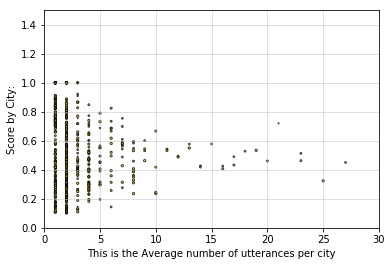

In [20]:
#Graph
super_graph = plt.scatter(oth_city, oth_mean, marker="o", c='gold', edgecolors="black", s=super_bubbles, alpha=0.75, label="super bugie by review")
not_bad_graph = plt.scatter(intent_city, intent_mean, marker="o", c='lightskyblue', edgecolors="black", s=not_bad_bubbles, alpha=0.75, label="Not Bad Bugie By review")

plt.ylim(0, 1.5)
plt.xlim(0, 30)
plt.grid(axis='both', alpha=0.5)
plt.xlabel("This is the Average number of utterances per city")
plt.ylabel("Score by City:")


3) Here we are looking at the signals we can get from the words used in the questions. This could be word frequency, word patterns, etc.

In [21]:
#Looking at the questions used
text_data_seriesb = oth["Recognition"]
text_data_seriesb.head(10)


0           alexa c' è traffico sulla strada del lavoro
1           alexa c' è traffico sulla strada del lavoro
2                 orari agenzia delle entrate di merate
3                           alexa informazioni traffico
4                           alexa informazioni traffico
5                                        alexa traffico
6                                        alexa traffico
7     cerca numero villaggio turistico capo vaticano...
8     cerca numero villaggio turistico capo vaticano...
10                a che ora apre il bennet di cornaredo
Name: Recognition, dtype: object

In [22]:
#

RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
wordsb = (text_data_seriesb
           .str.lower()
           .replace([r'\(','\)','\|','\,','\.','\?','\!','\_','\-','\:','\"','\*',"\'", RE_stopwords], ['','','','','','','',' ','','','','','', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DF out of Counter
rsltb = pd.DataFrame(Counter(wordsb).most_common(top_N),
                    columns=['Word', 'Non-intent']).set_index('Word')
print(rsltb)

# plot
#rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

               Non-intent
Word                     
alexa                 601
numero                424
qual                  307
trova                 281
telefono              278
vicino                255
ora                   226
cerca                 187
ristorante            178
apre                  156
orari                 136
aperto                132
pizzeria              131
indirizzo             129
farmacia              104
dim                   102
vicina                 98
orario                 93
via                    92
aperta                 77
apertura               74
chiude                 68
san                    61
oggi                   59
farmacie               58
ristoranti             56
quali                  53
turno                  52
dici                   52
dam                    52
...                   ...
horror                  1
vomero                  1
samuele                 1
simpli                  1
petrocelli              1
tardis      

This is a mix of buckets, so most of the top words make sense, but not all of them.  Two of our top words are "dim"(part of the word "dimmi" or "tell me") and "dam"(part of the word "dammi" or "give me").  This tells us that our ASR is systematically separating those words into two sounds.  Those partial words occur in a large number of questions, so we need to make sure our models can understand that word separation and that no ranking errors are created.  We can also get an idea of distribution of questions between telephone, address, and hours in general.  The exact same code could be run on TTS to see if the two correspond, i.e. if the instances of key words denoting hours, and those that give hours are around the same in number and percentage of total utterances.

In [23]:
text_data_seriesp = intent["Recognition"]
text_data_seriesp.head(10)

9                 a che ora chiude il bussoleno
19                  alexa il carrefour è aperto
20    fra quanto tempo chiude il coin a brescia
21    fra quanto tempo chiude il coin a brescia
25         a che ora apre il conad di un minion
26         a che ora apre il conad di un minion
50                      orari decathlon vignate
60                         alexa quando apre la
61                         alexa quando apre la
62                         alexa quando apre la
Name: Recognition, dtype: object

As follows, we look at the most used words in a particular bucket

In [24]:
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
# replace '|'-->' ' and drop all stopwords
wordsp = (text_data_seriesp
           .str.lower()
           .replace([r'\(','\)','\|','\,','\.','\?','\!','\_','\-','\:','\"','\*',"\'", RE_stopwords], ['','','','','','','',' ','','','','','', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DF out of Counter
rsltp = pd.DataFrame(Counter(wordsp).most_common(top_N),
                    columns=['Word', 'With_Intent']).set_index('With_Intent')
print(rsltp)

# plot
#rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

                     Word
With_Intent              
26                  alexa
19                    ora
17                   apre
15                 aperto
13                  orari
11                   qual
10               apertura
10                 vicino
9                  orario
9                      me
8                farmacia
8                libreria
8                  natale
7                  chiude
7                     dim
6                  aperta
5                    oggi
4                  quando
4                  centro
4                  numero
4                 firenze
4                  aperte
4                  chiusa
3                 brescia
3               indirizzo
3                pizzeria
3               trattoria
3               esselunga
3               vimercate
3                   quali
...                   ...
1               panificio
1               valentina
1                    shop
1                   villa
1              mediaworld
1           

In [25]:
rsltp_2 = pd.DataFrame(Counter(wordsp).most_common(top_N),
                    columns=['Word', 'With_Intent'])
print(rsltp_2)

             Word  With_Intent
0           alexa           26
1             ora           19
2            apre           17
3          aperto           15
4           orari           13
5            qual           11
6        apertura           10
7          vicino           10
8          orario            9
9              me            9
10       farmacia            8
11       libreria            8
12         natale            8
13         chiude            7
14            dim            7
15         aperta            6
16           oggi            5
17         quando            4
18         centro            4
19         numero            4
20        firenze            4
21         aperte            4
22         chiusa            4
23        brescia            3
24      indirizzo            3
25       pizzeria            3
26      trattoria            3
27      esselunga            3
28      vimercate            3
29          quali            3
..            ...          ...
124     

Here we can see the most used words for asking about hours(hours, open, clossed, close, today, when, etc.), the most comman placeTypes(pharmacy, bookstore, etc.), and cities where they ask for hours the most and least(Florence, Brescia, etc.)

In [26]:
odd_word = list({s for s in wordsp if s not in wordsb})
print(odd_word)


['gerenzano', 'new', 'vimercate', 'fra', 'central', 'brusson', 'rescaldina', 'random', 'toy', 'valeggio', 'ama', 'poggio', 'astragon', 'pordenone', 'borgo', 'maggio', 'contadino', 'audace', 'caronno', 'minion', 'ben', 'moulin', 'man', 'bussoleno', 'mincio', 'piccolino', 'pertusella', 'tedesco', 'cisalfa', 'renatico', 'lì', 'nottingham', 'primo', 'coin', 'lecco']


In [27]:
odd_wordres = pd.DataFrame(Counter(odd_word).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
print(odd_wordres)


            Frequency
Word                 
gerenzano           1
new                 1
vimercate           1
fra                 1
central             1
brusson             1
rescaldina          1
random              1
toy                 1
valeggio            1
ama                 1
poggio              1
astragon            1
pordenone           1
borgo               1
maggio              1
contadino           1
audace              1
caronno             1
minion              1
ben                 1
moulin              1
man                 1
bussoleno           1
mincio              1
piccolino           1
pertusella          1
tedesco             1
cisalfa             1
renatico            1
lì                  1
nottingham          1
primo               1
coin                1
lecco               1


Conclusion of 2nd section: Some of these signals are useful and others are not.  The Product Managers need to make their needs clear in order to work backwards from their needs.

3) The third section is using NaiveBayes ML models to the same purpose, to bring out interesting signals from our data set, although much work would need to be done to get all of the parameters right. It would also be better to try with different types of models, nearest neighbor models for example.  Here, we principally use key words form questions to query in order to gage the predictive value of the words themselves. Our data set is small, just 2000 utterances, and this exercise is just exploratory in nature.


In [29]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
try:
    sc
    spark
except NameError:
    sc = SparkContext('local')
    spark = SparkSession(sc)

from pyspark import SparkFiles
# url ="https://s3.amazonaws.com/dataviz-curriculum/day_2/yelp_reviews.csv"
# spark.sparkContext.addFile(url)
Intent = spark.read.csv("tool_testing.csv", sep=",", header=True)
Intent = Intent.na.drop(subset=["Recognition", "Score"])
# stars = stars.sample(False, 0.1, 0)

# Show DataFrame
Intent.show()

+--------------------+------------+-------------------+--------------------+--------------------+--------------------+----------------+--------------------+---------------+-----------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+
|          Audio Link|Decoder used|        Date / Time|       Transcription|         Recognition|                Diff|Annotated Domain|    Annotated Intent|Annotated Slots| NLU Domain|              Intent|      desired_answer|           NLU Slots|             Score|                 TTS|          TTS_Intent|                city|          Latitude|         Longitude|      Tessaract Link|
+--------------------+------------+-------------------+--------------------+--------------------+--------------------+----------------+--------------------+---------------+-----------+--------------------+-----------------

In [30]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('pandasToSparkDF').getOrCreate()
from pyspark.sql.types import *

mySchema = StructType([ StructField("Recognition", StringType(), True)\
                       ,StructField("length", IntegerType(), True)])

In [31]:
Words_df = spark.createDataFrame(rsltp_2,schema=mySchema)
type(Words_df)

pyspark.sql.dataframe.DataFrame

In [32]:
Words_df.show()

+-----------+------+
|Recognition|length|
+-----------+------+
|      alexa|    26|
|        ora|    19|
|       apre|    17|
|     aperto|    15|
|      orari|    13|
|       qual|    11|
|   apertura|    10|
|     vicino|    10|
|     orario|     9|
|         me|     9|
|   farmacia|     8|
|   libreria|     8|
|     natale|     8|
|     chiude|     7|
|        dim|     7|
|     aperta|     6|
|       oggi|     5|
|     quando|     4|
|     centro|     4|
|     numero|     4|
+-----------+------+
only showing top 20 rows



In [33]:
from pyspark.sql.functions import length
# # Create a length column to be used as a future feature 
Intent = Intent.withColumn('length', length(Intent['Recognition']))
# data_df.show()
import pyspark.sql.functions as func
# means = df.groupby("id").agg(func.mean("col1"))
from pyspark.sql.functions import col, expr, when

Intent_words = Words_df.withColumn(
    'class', when((col("length") > '5'), 'positive')
    .otherwise("negative")
)
Intent_words.show()

+-----------+------+--------+
|Recognition|length|   class|
+-----------+------+--------+
|      alexa|    26|positive|
|        ora|    19|positive|
|       apre|    17|positive|
|     aperto|    15|positive|
|      orari|    13|positive|
|       qual|    11|positive|
|   apertura|    10|positive|
|     vicino|    10|positive|
|     orario|     9|positive|
|         me|     9|positive|
|   farmacia|     8|positive|
|   libreria|     8|positive|
|     natale|     8|positive|
|     chiude|     7|positive|
|        dim|     7|positive|
|     aperta|     6|positive|
|       oggi|     5|negative|
|     quando|     4|negative|
|     centro|     4|negative|
|     numero|     4|negative|
+-----------+------+--------+
only showing top 20 rows



In [34]:
Intent_df = Intent.withColumn(
    'class', when((col("Recognition") == col("Transcription")), 'positive')
    .otherwise("negative")
)

In [35]:
# hours.head()

In [36]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
# Create all the features to the data set
pos_neg_to_num = StringIndexer(inputCol='class',outputCol='label')
tokenizer = Tokenizer(inputCol="Recognition", outputCol="token_text")
stopremove = set("Italian") 
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
hashingTF = HashingTF(inputCol="token_text", outputCol='hash_token')
idf = IDF(inputCol='hash_token', outputCol='idf_token')


In [37]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

# Create feature vectors
clean_up = VectorAssembler(inputCols=['idf_token', 'length'], outputCol='features')

In [38]:
from pyspark.ml import Pipeline
data_prep_pipeline = Pipeline(stages=[pos_neg_to_num, tokenizer, stopremove, hashingTF, idf, clean_up])

In [39]:
print(Intent_df.count())
# cleaner = data_prep_pipeline.fit(Intent)

103


In [40]:
cleaner_words = data_prep_pipeline.fit(Intent_words)

In [41]:
print(type(cleaner_words))
print(type(Intent_words))

<class 'pyspark.ml.pipeline.PipelineModel'>
<class 'pyspark.sql.dataframe.DataFrame'>


In [42]:
cleaner_no_diff = data_prep_pipeline.fit(Intent_df)

In [43]:
print(type(cleaner_no_diff))
print(type(Intent_df))

<class 'pyspark.ml.pipeline.PipelineModel'>
<class 'pyspark.sql.dataframe.DataFrame'>


In [44]:
cleaned_words = cleaner_words.transform(Intent_words)

In [45]:
cleaned_no_diff = cleaner_no_diff.transform(Intent_df)

In [46]:
cleaned_words.select(['label', 'features']).show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(262145,[242777,2...|
|  1.0|(262145,[30123,26...|
|  1.0|(262145,[175264,2...|
|  1.0|(262145,[207847,2...|
|  1.0|(262145,[158326,2...|
|  1.0|(262145,[140962,2...|
|  1.0|(262145,[125857,2...|
|  1.0|(262145,[125316,2...|
|  1.0|(262145,[49097,26...|
|  1.0|(262145,[221047,2...|
|  1.0|(262145,[152500,2...|
|  1.0|(262145,[77425,26...|
|  1.0|(262145,[260699,2...|
|  1.0|(262145,[166531,2...|
|  1.0|(262145,[96737,26...|
|  1.0|(262145,[40689,26...|
|  0.0|(262145,[24765,26...|
|  0.0|(262145,[187317,2...|
|  0.0|(262145,[118528,2...|
|  0.0|(262145,[261201,2...|
+-----+--------------------+
only showing top 20 rows



In [47]:
cleaned_no_diff.select(['label', 'features']).show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(262145,[108197,1...|
|  0.0|(262145,[28921,61...|
|  0.0|(262145,[39014,59...|
|  0.0|(262145,[10173,12...|
|  0.0|(262145,[55741,83...|
|  1.0|(262145,[18497,55...|
|  1.0|(262145,[18497,55...|
|  0.0|(262145,[39014,59...|
|  0.0|(262145,[39014,55...|
|  1.0|(262145,[39389,10...|
|  0.0|(262145,[49097,61...|
|  1.0|(262145,[61093,10...|
|  1.0|(262145,[45297,11...|
|  1.0|(262145,[35572,79...|
|  0.0|(262145,[30123,61...|
|  1.0|(262145,[61093,73...|
|  1.0|(262145,[8431,610...|
|  1.0|(262145,[8538,393...|
|  1.0|(262145,[75029,78...|
|  1.0|(262145,[20591,61...|
+-----+--------------------+
only showing top 20 rows



Model using intent words

In [48]:

from pyspark.ml.classification import NaiveBayes
# Break data down into a training set and a testing set
training, testing = cleaned_words.randomSplit([0.7, 0.3])

# Create a Naive Bayes model and fit training data
nb = NaiveBayes()
predictor = nb.fit(training)

In [49]:
test_results = predictor.transform(testing)
# print(testing.columns)
# print(test_results.columns)
# test_results.toPandas().to_csv("test_results.csv")
test_results.show(5)

+-----------+------+--------+-----+----------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|Recognition|length|   class|label|token_text|stop_tokens|          hash_token|           idf_token|            features|       rawPrediction|         probability|prediction|
+-----------+------+--------+-----+----------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|     adesso|     3|negative|  0.0|  [adesso]|   [adesso]|(262144,[39603],[...|(262144,[39603],[...|(262145,[39603,26...|[-76.341833832881...|[0.95605291076664...|       0.0|
|     aperte|     4|negative|  0.0|  [aperte]|   [aperte]|(262144,[53169],[...|(262144,[53169],[...|(262145,[53169,26...|[-83.656021476955...|[0.96766601548961...|       0.0|
|       apre|    17|positive|  1.0|    [apre]|     [apre]|(262144,[175264],...|(262144,[175264],...|(262145,[175264,2...|[-17

In [50]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(test_results)
print("Accuracy of model at predicting reviews was: %f" % acc)

Accuracy of model at predicting reviews was: 0.829170


Model using "no diff" utterances, as in where recognition and annotation are the same

In [51]:
training, testing = cleaned_no_diff.randomSplit([0.7, 0.3])
predictor_no_diff = nb.fit(training)

In [52]:
test_results = predictor_no_diff.transform(testing)

In [53]:
acc_eval_no_diff = MulticlassClassificationEvaluator()
acc_no_diff = acc_eval_no_diff.evaluate(test_results)
print("Accuracy of model at predicting reviews was: %f" % acc)

Accuracy of model at predicting reviews was: 0.829170


Conclusion from 3rd section: more data is necessary, and these methods need to be honed, however, some value very well could be attained by pulling out meaning from the questions customers are asking.